# Data Attack type classifier

#### Resume

**Objective:** Develop a data classifier that takes into acount CelebA data attack types classification - [CelebA Paper](https://ar5iv.labs.arxiv.org/html/2007.12342?utm_source=chatgpt.com)

CelebA dataset classifies attack types into two categories (Level A1, and Level A2):
*   A1 - Print
  *   A2 - Photo
  *   A2 - Poster
  *   A2 - A4
*   A1 - Paper Cut
  *   A2 - Face Mask
  *   A2 - Upper Body Mask
  *   A2 - Region Mask
*   A1 - Replay
  *   A2 - PC
  *   A2 - Pad
  *   A2 - Phone
*   A1 - 3D
  *   A2 - Mask

To make it easier on the first trained model and POC version, we will focus on just classifing data considering the A1 level of data.
Data interpolation:

1.   Live data: taged with [0] on 40th data input on .csv
2.   A1 - Print attack: taged with [1,2,3] on the data input on .csv
3.   A1 - Paper cut attack: taged with [4,5,6] on the data input on .csv
4.   A1 - Replay attack: taged with [7,8,9] on the data input on .csv
5.   A1 - 3D attack: taged with [10] on the data input on .csv


### Data Loader

Keras tensorflow -> read from csv(json)
*  Partition data based on file folder (Data/test/4931/spoof)

In [2]:
! pip install pandas tensorflow matplotlib numpy scikit-learn mlxtend

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
#modelos selecionado para 2nd experimento
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import MobileNetV3Small
#para early stopping
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
#para metricas
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import sklearn.metrics as skmetrics

2025-05-19 11:31:01.487737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747668661.582118   27229 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747668661.605993   27229 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747668661.751417   27229 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747668661.751452   27229 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747668661.751456   27229 computation_placer.cc:177] computation placer alr

In [2]:
HEIGHT = 224
WIDTH = 224
BATCH_SIZE = 32

In [3]:
path_ = '/home/fmanzoni-lx/Documents/Compal/CelebA-Spoof-Segregado-2/'
trainPath = path_ + 'train/'
testPath = path_ + 'test/'

In [4]:
traindgen = ImageDataGenerator(
                rotation_range=20,
                zoom_range=0.15,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.15,
                horizontal_flip=True,
                rescale=1. / 255,
                fill_mode="nearest",
                validation_split = 0.1
            )
testdgen = ImageDataGenerator(rescale=1. / 255)

In [5]:
class_mode='categorical'
traingen = traindgen.flow_from_directory(
                trainPath,
                target_size=(HEIGHT, WIDTH),
                batch_size=BATCH_SIZE,
                class_mode=class_mode,
                shuffle=True,
                seed=1337,
                subset='training'
            )
valgen = traindgen.flow_from_directory(
                trainPath,
                target_size=(HEIGHT, WIDTH),
                batch_size=BATCH_SIZE,
                class_mode=class_mode,
                shuffle=False,
                subset='validation'
            )
testgen = testdgen.flow_from_directory(
                testPath,
                target_size=(HEIGHT, WIDTH),
                batch_size=BATCH_SIZE,
                class_mode=class_mode,
                shuffle=False
            )

Found 144502 images belonging to 3 classes.
Found 16054 images belonging to 3 classes.
Found 17838 images belonging to 3 classes.


In [6]:
#modelo com VGG16
base_model = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(len(valgen.class_indices), activation='softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])
model.summary()

I0000 00:00:1747668735.075633   27229 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2604 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,243,075 (58.15 MB)

 Trainable params: 15,243,075 (58.15 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#modelo com ResNet50V2
base_model2 = ResNet50V2(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model2.output)
x = Dense(1024, activation='relu')(x)
output = Dense(len(valgen.class_indices), activation='softmax')(x)
model2 = Model(inputs=[base_model2.input], outputs=[output])
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 25,666,051 (97.91 MB)

 Trainable params: 25,620,611 (97.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [8]:
base_model3 = MobileNetV3Small(
                input_shape=(224, 224, 3),
                weights='imagenet',
                include_top=False
            )

x = GlobalAveragePooling2D()(base_model3.output)
x = Dense(1024, activation='relu')(x)
output = Dense(len(valgen.class_indices), activation='softmax')(x)

model3 = Model(inputs=[base_model3.input], outputs=[output])

model3.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,533,043 (5.85 MB)

 Trainable params: 1,520,931 (5.80 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [9]:
cutoffvgg = len( model.layers)-7
i = 0
for layer in model.layers:
  layer.trainable = i>=cutoffvgg
  i+=1

cutoffrn = len( model2.layers)-16
i = 0
for layer in model2.layers:
  layer.trainable = i>=cutoffrn
  i+=1

cutoffmbn = len( model3.layers)-16
i = 0
for layer in model3.layers:
  layer.trainable = i>=cutoffmbn
  i+=1

In [10]:
for layer in model.layers:
  print( layer, [i.shape for i in layer.weights], layer.trainable)

<InputLayer name=input_layer, built=True> [] False
<Conv2D name=block1_conv1, built=True> [TensorShape([3, 3, 3, 64]), TensorShape([64])] False
<Conv2D name=block1_conv2, built=True> [TensorShape([3, 3, 64, 64]), TensorShape([64])] False
<MaxPooling2D name=block1_pool, built=True> [] False
<Conv2D name=block2_conv1, built=True> [TensorShape([3, 3, 64, 128]), TensorShape([128])] False
<Conv2D name=block2_conv2, built=True> [TensorShape([3, 3, 128, 128]), TensorShape([128])] False
<MaxPooling2D name=block2_pool, built=True> [] False
<Conv2D name=block3_conv1, built=True> [TensorShape([3, 3, 128, 256]), TensorShape([256])] False
<Conv2D name=block3_conv2, built=True> [TensorShape([3, 3, 256, 256]), TensorShape([256])] False
<Conv2D name=block3_conv3, built=True> [TensorShape([3, 3, 256, 256]), TensorShape([256])] False
<MaxPooling2D name=block3_pool, built=True> [] False
<Conv2D name=block4_conv1, built=True> [TensorShape([3, 3, 256, 512]), TensorShape([512])] False
<Conv2D name=block4_co

In [11]:
for layer in model2.layers:
  print( layer, [i.shape for i in layer.weights], layer.trainable)

<InputLayer name=input_layer_1, built=True> [] False
<ZeroPadding2D name=conv1_pad, built=True> [] False
<Conv2D name=conv1_conv, built=True> [TensorShape([7, 7, 3, 64]), TensorShape([64])] False
<ZeroPadding2D name=pool1_pad, built=True> [] False
<MaxPooling2D name=pool1_pool, built=True> [] False
<BatchNormalization name=conv2_block1_preact_bn, built=True> [TensorShape([64]), TensorShape([64]), TensorShape([64]), TensorShape([64])] False
<Activation name=conv2_block1_preact_relu, built=True> [] False
<Conv2D name=conv2_block1_1_conv, built=True> [TensorShape([1, 1, 64, 64])] False
<BatchNormalization name=conv2_block1_1_bn, built=True> [TensorShape([64]), TensorShape([64]), TensorShape([64]), TensorShape([64])] False
<Activation name=conv2_block1_1_relu, built=True> [] False
<ZeroPadding2D name=conv2_block1_2_pad, built=True> [] False
<Conv2D name=conv2_block1_2_conv, built=True> [TensorShape([3, 3, 64, 64])] False
<BatchNormalization name=conv2_block1_2_bn, built=True> [TensorShape(

In [12]:
for layer in model3.layers:
  print( layer, [i.shape for i in layer.weights], layer.trainable)

<InputLayer name=input_layer_2, built=True> [] False
<Rescaling name=rescaling, built=True> [] False
<Conv2D name=conv, built=True> [TensorShape([3, 3, 3, 16])] False
<BatchNormalization name=conv_bn, built=True> [TensorShape([16]), TensorShape([16]), TensorShape([16]), TensorShape([16])] False
<Activation name=activation, built=True> [] False
<ZeroPadding2D name=expanded_conv_depthwise_pad, built=True> [] False
<DepthwiseConv2D name=expanded_conv_depthwise, built=True> [TensorShape([3, 3, 16, 1])] False
<BatchNormalization name=expanded_conv_depthwise_bn, built=True> [TensorShape([16]), TensorShape([16]), TensorShape([16]), TensorShape([16])] False
<ReLU name=re_lu, built=True> [] False
<GlobalAveragePooling2D name=expanded_conv_squeeze_excite_avg_pool, built=True> [] False
<Conv2D name=expanded_conv_squeeze_excite_conv, built=True> [TensorShape([1, 1, 16, 8]), TensorShape([8])] False
<ReLU name=expanded_conv_squeeze_excite_relu, built=True> [] False
<Conv2D name=expanded_conv_squeeze

### Treino, Validação e Teste

In [13]:
steps_per_epoch = len(traingen)
validation_steps = len(valgen)
optimizer = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.85, beta_2=0.999)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
EPOCHS = 200

# Define adaptive LR callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',       # or 'val_accuracy'
    factor=0.1,               # reduce LR by a factor of 0.5
    patience=3,               # after 5 epochs with no improvement
    min_lr=1e-7,              # don't go below this
    verbose=1
)

In [14]:
callbacksA =    [EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1, restore_best_weights=True), lr_scheduler,
                 ModelCheckpoint('best_modelA.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)]
callbacksB =    [EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True), lr_scheduler,
                 ModelCheckpoint('best_modelB.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)]
callbacksC =    [EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True), lr_scheduler,
                 ModelCheckpoint('best_modelC.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)]

### VGG16

In [15]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [16]:
results = model.fit(
            x=traingen,
            steps_per_epoch=steps_per_epoch,
            epochs=EPOCHS,
            validation_data=valgen,
            validation_steps=validation_steps,
            callbacks=callbacksA
          )

/home/fmanzoni-lx/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200


/home/fmanzoni-lx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
I0000 00:00:1747668912.310046   27631 service.cc:152] XLA service 0x77e42c004ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747668912.310088   27631 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2025-05-19 11:35:12.396478: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747668913.226239   27631 cuda_dnn.cc:529] Loaded cuDNN version 91000
2025-05-19 11:35:14.142526: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k

2126/4516 ━━━━━━━━━━━━━━━━━━━━ 24:55 626ms/step - accuracy: 0.8445 - loss: 0.3785

2025-05-19 11:57:43.975919: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[22,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[22,3,224,224]{3,2,1,0} %bitcast.2368, f32[64,3,3,3]{3,2,1,0} %bitcast.2375, f32[64]{0} %bitcast.2377), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/block1_conv1_1/convolution" source_file="/home/fmanzoni-lx/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-19 11:57:44.440544: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] O

4516/4516 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.8829 - loss: 0.2925

2025-05-19 12:21:42.044041: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.49 = (f32[32,512,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,512,14,14]{3,2,1,0} %bitcast.957, f32[512,512,3,3]{3,2,1,0} %bitcast.964, f32[512]{0} %bitcast.966), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/block5_conv1_1/convolution" source_file="/home/fmanzoni-lx/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-19 12:26:03.708543: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] O


Epoch 1: val_loss improved from inf to 0.11001, saving model to best_modelA.h5


4516/4516 ━━━━━━━━━━━━━━━━━━━━ 3056s 671ms/step - accuracy: 0.8830 - loss: 0.2925 - val_accuracy: 0.9593 - val_loss: 0.1100 - learning_rate: 1.0000e-04
Epoch 2/200
4516/4516 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9653 - loss: 0.0957
Epoch 2: val_loss improved from 0.11001 to 0.06704, saving model to best_modelA.h5


4516/4516 ━━━━━━━━━━━━━━━━━━━━ 2743s 607ms/step - accuracy: 0.9653 - loss: 0.0957 - val_accuracy: 0.9760 - val_loss: 0.0670 - learning_rate: 1.0000e-04
Epoch 3/200
4516/4516 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.9754 - loss: 0.0678
Epoch 3: val_loss improved from 0.06704 to 0.06462, saving model to best_modelA.h5


4516/4516 ━━━━━━━━━━━━━━━━━━━━ 3640s 806ms/step - accuracy: 0.9754 - loss: 0.0678 - val_accuracy: 0.9758 - val_loss: 0.0646 - learning_rate: 1.0000e-04
Epoch 4/200
 587/4516 ━━━━━━━━━━━━━━━━━━━━ 42:14 645ms/step - accuracy: 0.9828 - loss: 0.0512

KeyboardInterrupt: 

#### VGG16 - Trained results

In [ ]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('acurácia')
plt.xlabel('Época')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('acurácia')
plt.xlabel('Época')
plt.legend(['train', 'val'])
plt.show()

In [17]:
y_predA = model.predict( x=testgen).argmax(axis=1)
y_trueA = testgen.classes
confmatrixA = confusion_matrix( y_trueA, y_predA)
scoresA = model.evaluate( x=testgen, verbose=1)
print('Erro teste: ', scoresA[0])
print('Acuracia teste: ', scoresA[1])

/home/fmanzoni-lx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


557/558 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step

2025-05-19 14:21:42.169125: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.39 = (f32[14,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[14,3,224,224]{3,2,1,0} %bitcast.496, f32[64,3,3,3]{3,2,1,0} %bitcast.503, f32[64]{0} %bitcast.505), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/block1_conv1_1/convolution" source_file="/home/fmanzoni-lx/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-05-19 14:21:42.300088: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omit

558/558 ━━━━━━━━━━━━━━━━━━━━ 172s 305ms/step
558/558 ━━━━━━━━━━━━━━━━━━━━ 159s 285ms/step - accuracy: 0.9914 - loss: 0.0249
Erro teste:  0.022459248080849648
Acuracia teste:  0.9919273257255554


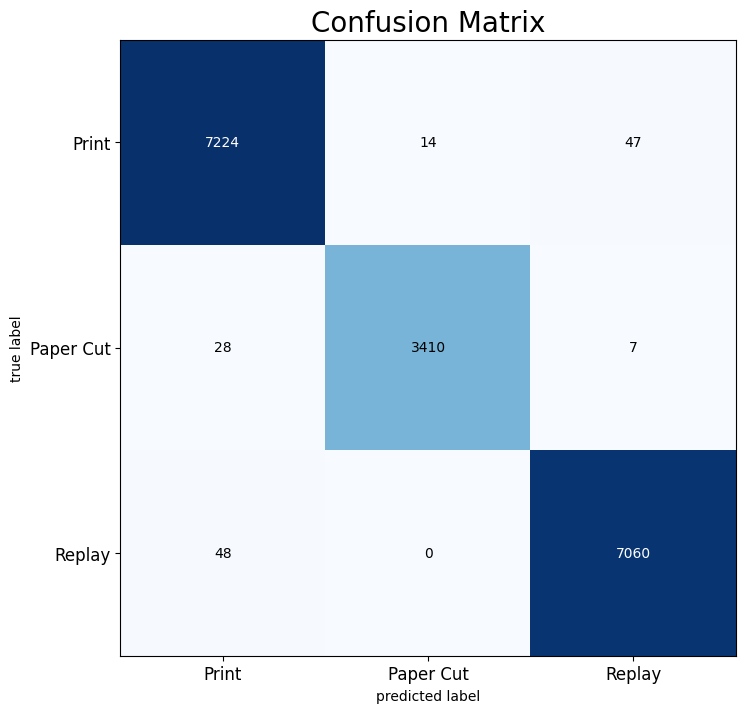



Outras métricas



{'spoof_1_print': 0, 'spoof_2_paper_cut': 1, 'spoof_3_replay': 2}
0
Precision     : 98.96%
Recall        : 99.16%
F1-Score      : 99.06%
1
Precision     : 99.59%
Recall        : 98.98%
F1-Score      : 99.29%
2
Precision     : 99.24%
Recall        : 99.32%
F1-Score      : 99.28%


In [19]:
CM = confusion_matrix(y_trueA, y_predA)
classes =  ['Print','Paper Cut','Replay']

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), classes, fontsize=12)
plt.yticks(range(3), classes, fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.show()


precision = precision_score(y_trueA, y_predA, average=None)
recall = recall_score(y_trueA, y_predA, average=None)
f1 = f1_score(y_trueA, y_predA, average=None)
print("\n")
print("Outras métricas")
print("\n\n")
print(testgen.class_indices)
for i in range(0,3):
    print(i)
    print("%s%.2f%s"% ("Precision     : ", precision[i]*100, "%"))
    print("%s%.2f%s"% ("Recall        : ", recall[i]*100,    "%"))
    print("%s%.2f%s"% ("F1-Score      : ", f1[i]*100,        "%"))

### RESNET50 v2

In [ ]:
model2.compile(optimizer=optimizer,#os
              loss=loss,
              metrics=metrics)

In [ ]:
resultsB = model2.fit(
              x=traingen,
              steps_per_epoch=steps_per_epoch,
              epochs=EPOCHS,
              validation_data=valgen,
              validation_steps=validation_steps,
              callbacks=callbacksB
            )

#### Results

In [ ]:
plt.plot(resultsB.history['accuracy'])
plt.plot(resultsB.history['val_accuracy'])
plt.title('Acurácia do Modelo')
plt.ylabel('acurácia')
plt.xlabel('Época')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
plt.plot(resultsB.history['loss'])
plt.plot(resultsB.history['val_loss'])
plt.title('Loss do Modelo')
plt.ylabel('loss')
plt.xlabel('Época')
plt.legend(['train', 'test'])
plt.show()

In [ ]:
y_predB = model2.predict( x=testgen).argmax(axis=1)
y_trueB = testgen.classes
scoresB = model2.evaluate( x=testgen, verbose=1)
print('Erro teste: ', scoresB[0])
print('Acuracia teste: ', scoresB[1])

In [ ]:
CM = confusion_matrix(y_trueB, y_predB)
classes =  ['covid19','normal','pneumonia']

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), classes, fontsize=12)
plt.yticks(range(3), classes, fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.show()


precision = precision_score(y_trueB, y_predB, average=None)
recall = recall_score(y_trueB, y_predB, average=None)
f1 = f1_score(y_trueB, y_predB, average=None)
print("\n")
print("Outras métricas")
print("\n\n")
print(testgen.class_indices)
for i in range(0,3):
    print(i)
    print("%s%.2f%s"% ("Precision     : ", precision[i]*100, "%"))
    print("%s%.2f%s"% ("Recall        : ", recall[i]*100,    "%"))
    print("%s%.2f%s"% ("F1-Score      : ", f1[i]*100,        "%"))

### Mobile Net V3 Small

In [119]:
model3.compile(optimizer=optimizer,#os
              loss=loss,
              metrics=metrics)

In [120]:
resultsC = model3.fit(
              x=traingen,
              steps_per_epoch=steps_per_epoch,
              epochs=EPOCHS,
              validation_data=valgen,
              validation_steps=validation_steps,
              callbacks= callbacksC
            )

Epoch 1/200


/home/fmanzoni-lx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2358']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8008 - loss: 0.4595
Epoch 1: val_loss improved from inf to 1.60910, saving model to best_modelC.h5


909/909 ━━━━━━━━━━━━━━━━━━━━ 517s 528ms/step - accuracy: 0.8008 - loss: 0.4593 - val_accuracy: 0.4000 - val_loss: 1.6091 - learning_rate: 1.0000e-04
Epoch 2/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9471 - loss: 0.1438
Epoch 2: val_loss improved from 1.60910 to 1.30710, saving model to best_modelC.h5


909/909 ━━━━━━━━━━━━━━━━━━━━ 401s 441ms/step - accuracy: 0.9471 - loss: 0.1438 - val_accuracy: 0.4025 - val_loss: 1.3071 - learning_rate: 1.0000e-04
Epoch 3/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9671 - loss: 0.0901
Epoch 3: val_loss did not improve from 1.30710
909/909 ━━━━━━━━━━━━━━━━━━━━ 408s 448ms/step - accuracy: 0.9671 - loss: 0.0901 - val_accuracy: 0.3991 - val_loss: 1.9366 - learning_rate: 1.0000e-04
Epoch 4/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9726 - loss: 0.0694
Epoch 4: val_loss did not improve from 1.30710
909/909 ━━━━━━━━━━━━━━━━━━━━ 393s 432ms/step - accuracy: 0.9726 - loss: 0.0694 - val_accuracy: 0.4090 - val_loss: 2.7377 - learning_rate: 1.0000e-04
Epoch 5/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9783 - loss: 0.0604
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 5: val_loss did not improve from 1.30710
909/909 ━━━━━━━━━━━━━━━━━━━━ 407s 447ms/step - accuracy: 0.9783 - lo

909/909 ━━━━━━━━━━━━━━━━━━━━ 454s 499ms/step - accuracy: 0.9859 - loss: 0.0400 - val_accuracy: 0.7130 - val_loss: 1.2469 - learning_rate: 1.0000e-05
Epoch 8/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9875 - loss: 0.0352
Epoch 8: val_loss improved from 1.24689 to 0.31641, saving model to best_modelC.h5


909/909 ━━━━━━━━━━━━━━━━━━━━ 397s 437ms/step - accuracy: 0.9875 - loss: 0.0352 - val_accuracy: 0.8981 - val_loss: 0.3164 - learning_rate: 1.0000e-05
Epoch 9/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9869 - loss: 0.0357
Epoch 9: val_loss improved from 0.31641 to 0.13705, saving model to best_modelC.h5


909/909 ━━━━━━━━━━━━━━━━━━━━ 440s 484ms/step - accuracy: 0.9869 - loss: 0.0357 - val_accuracy: 0.9548 - val_loss: 0.1370 - learning_rate: 1.0000e-05
Epoch 10/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9889 - loss: 0.0298
Epoch 10: val_loss improved from 0.13705 to 0.06244, saving model to best_modelC.h5


909/909 ━━━━━━━━━━━━━━━━━━━━ 472s 519ms/step - accuracy: 0.9889 - loss: 0.0298 - val_accuracy: 0.9783 - val_loss: 0.0624 - learning_rate: 1.0000e-05
Epoch 11/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.9883 - loss: 0.0319
Epoch 11: val_loss improved from 0.06244 to 0.04798, saving model to best_modelC.h5


909/909 ━━━━━━━━━━━━━━━━━━━━ 485s 533ms/step - accuracy: 0.9883 - loss: 0.0319 - val_accuracy: 0.9802 - val_loss: 0.0480 - learning_rate: 1.0000e-05
Epoch 12/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9893 - loss: 0.0303
Epoch 12: val_loss improved from 0.04798 to 0.03841, saving model to best_modelC.h5


909/909 ━━━━━━━━━━━━━━━━━━━━ 443s 488ms/step - accuracy: 0.9893 - loss: 0.0303 - val_accuracy: 0.9873 - val_loss: 0.0384 - learning_rate: 1.0000e-05
Epoch 13/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9897 - loss: 0.0291
Epoch 13: val_loss did not improve from 0.03841
909/909 ━━━━━━━━━━━━━━━━━━━━ 436s 480ms/step - accuracy: 0.9897 - loss: 0.0291 - val_accuracy: 0.9817 - val_loss: 0.0527 - learning_rate: 1.0000e-05
Epoch 14/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9914 - loss: 0.0248
Epoch 14: val_loss did not improve from 0.03841
909/909 ━━━━━━━━━━━━━━━━━━━━ 447s 492ms/step - accuracy: 0.9914 - loss: 0.0248 - val_accuracy: 0.9833 - val_loss: 0.0443 - learning_rate: 1.0000e-05
Epoch 15/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9919 - loss: 0.0242
Epoch 15: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 15: val_loss did not improve from 0.03841
909/909 ━━━━━━━━━━━━━━━━━━━━ 442s 486ms/step - accuracy: 0.99

909/909 ━━━━━━━━━━━━━━━━━━━━ 424s 466ms/step - accuracy: 0.9914 - loss: 0.0255 - val_accuracy: 0.9851 - val_loss: 0.0365 - learning_rate: 1.0000e-06
Epoch 17/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9912 - loss: 0.0240
Epoch 17: val_loss improved from 0.03651 to 0.03523, saving model to best_modelC.h5


909/909 ━━━━━━━━━━━━━━━━━━━━ 444s 488ms/step - accuracy: 0.9912 - loss: 0.0240 - val_accuracy: 0.9861 - val_loss: 0.0352 - learning_rate: 1.0000e-06
Epoch 18/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9917 - loss: 0.0254
Epoch 18: val_loss improved from 0.03523 to 0.02458, saving model to best_modelC.h5


909/909 ━━━━━━━━━━━━━━━━━━━━ 434s 478ms/step - accuracy: 0.9917 - loss: 0.0254 - val_accuracy: 0.9901 - val_loss: 0.0246 - learning_rate: 1.0000e-06
Epoch 19/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0.9902 - loss: 0.0290
Epoch 19: val_loss did not improve from 0.02458
909/909 ━━━━━━━━━━━━━━━━━━━━ 432s 475ms/step - accuracy: 0.9902 - loss: 0.0290 - val_accuracy: 0.9879 - val_loss: 0.0383 - learning_rate: 1.0000e-06
Epoch 20/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.9912 - loss: 0.0242
Epoch 20: val_loss did not improve from 0.02458
909/909 ━━━━━━━━━━━━━━━━━━━━ 417s 459ms/step - accuracy: 0.9912 - loss: 0.0242 - val_accuracy: 0.9879 - val_loss: 0.0354 - learning_rate: 1.0000e-06
Epoch 21/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.9902 - loss: 0.0260
Epoch 21: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 21: val_loss did not improve from 0.02458
909/909 ━━━━━━━━━━━━━━━━━━━━ 411s 452ms/step - accuracy: 0.9902 - loss: 0.026

909/909 ━━━━━━━━━━━━━━━━━━━━ 407s 448ms/step - accuracy: 0.9929 - loss: 0.0220 - val_accuracy: 0.9923 - val_loss: 0.0223 - learning_rate: 1.0000e-07
Epoch 24/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9916 - loss: 0.0253
Epoch 24: val_loss did not improve from 0.02232
909/909 ━━━━━━━━━━━━━━━━━━━━ 397s 437ms/step - accuracy: 0.9916 - loss: 0.0253 - val_accuracy: 0.9882 - val_loss: 0.0304 - learning_rate: 1.0000e-07
Epoch 25/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.9908 - loss: 0.0242
Epoch 25: val_loss did not improve from 0.02232
909/909 ━━━━━━━━━━━━━━━━━━━━ 411s 452ms/step - accuracy: 0.9908 - loss: 0.0242 - val_accuracy: 0.9882 - val_loss: 0.0359 - learning_rate: 1.0000e-07
Epoch 26/200
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9911 - loss: 0.0232
Epoch 26: val_loss did not improve from 0.02232
909/909 ━━━━━━━━━━━━━━━━━━━━ 417s 459ms/step - accuracy: 0.9911 - loss: 0.0232 - val_accuracy: 0.9861 - val_loss: 0.0379 - learning_rate: 1

#### Results

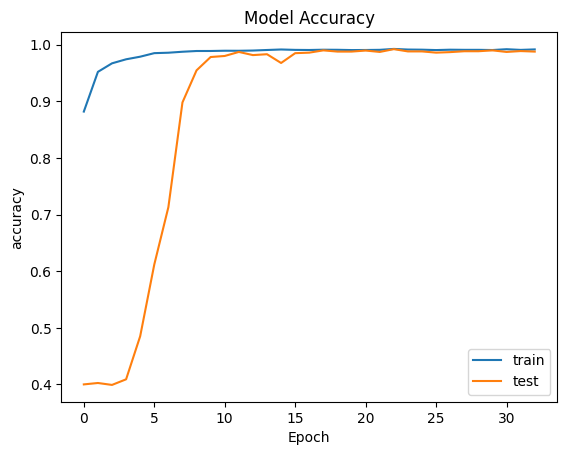

In [122]:
plt.plot(resultsC.history['accuracy'])
plt.plot(resultsC.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

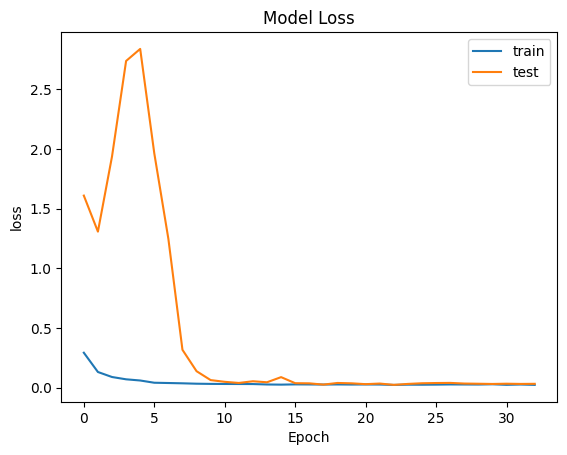

In [123]:
plt.plot(resultsC.history['loss'])
plt.plot(resultsC.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.show()

In [124]:
y_predC = model3.predict( x=testgen).argmax(axis=1)
y_trueC = testgen.classes
scoresC = model3.evaluate( x=testgen, verbose=1)
print('Test Error: ', scoresC[0])
print('Test Accuracy: ', scoresC[1])

/home/fmanzoni-lx/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/fmanzoni-lx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2358']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step

/home/fmanzoni-lx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_2358']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


106/106 ━━━━━━━━━━━━━━━━━━━━ 60s 496ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 401ms/step - accuracy: 0.5222 - loss: 3.2061
Test Error:  2.015733242034912
Test Accuracy:  0.6163895726203918


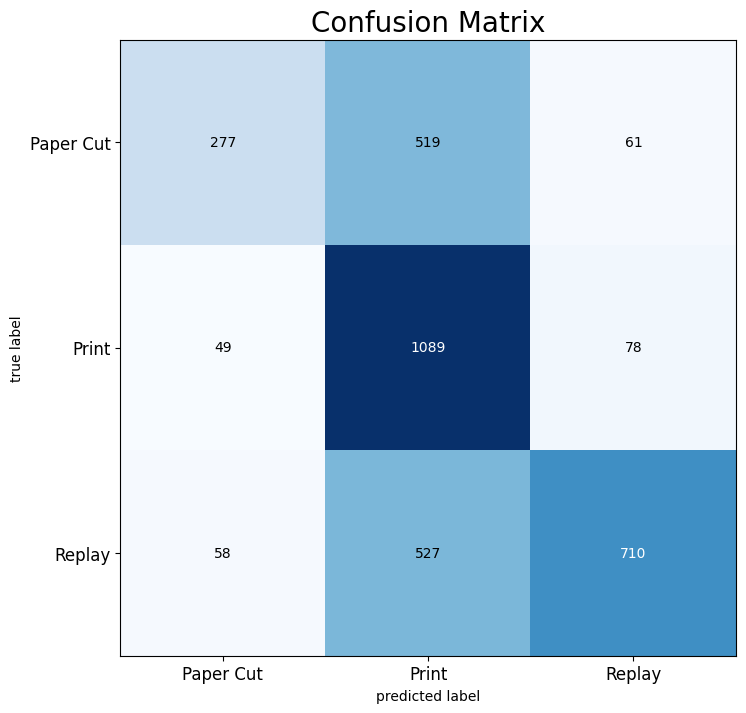



Outras métricas



{'spoof_paper_cut_2': 0, 'spoof_print_1': 1, 'spoof_replay_3': 2}
0
Precision     : 72.14%
Recall        : 32.32%
F1-Score      : 44.64%
1
Precision     : 51.01%
Recall        : 89.56%
F1-Score      : 65.00%
2
Precision     : 83.63%
Recall        : 54.83%
F1-Score      : 66.23%


In [125]:
CM = confusion_matrix(y_trueC, y_predC)
classes =  ['Paper Cut','Print','Replay']

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(3), classes, fontsize=12)
plt.yticks(range(3), classes, fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.show()

precision = precision_score(y_trueC, y_predC, average=None)
recall = recall_score(y_trueC, y_predC, average=None)
f1 = f1_score(y_trueC, y_predC, average=None)
print("\n")
print("Outras métricas")
print("\n\n")
print(testgen.class_indices)
for i in range(0,3):
    print(i)
    print("%s%.2f%s"% ("Precision     : ", precision[i]*100, "%"))
    print("%s%.2f%s"% ("Recall        : ", recall[i]*100,    "%"))
    print("%s%.2f%s"% ("F1-Score      : ", f1[i]*100,        "%"))